In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy.random as rd

In [17]:
with open('first_database.pkl', 'rb') as f:
    x,y = pickle.load(f)

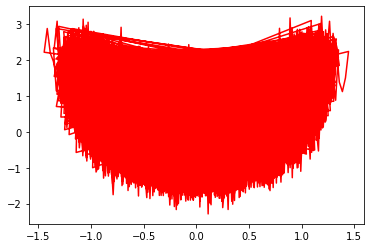

In [19]:
plt.plot(x,y, color='r')

In [40]:
#Initialisation
n = 100
m = 10
a = 5
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = [x[i] for i in ind]
y_selected = [y[i] for i in ind]

In [11]:
def create_graph(size, number_edge):
    if number_edge == 0:
        graph = np.eye(size)
        return graph
    else: 
        graph = create_graph(size, number_edge - 1)
        zeros_index = []
        for i in range(size):
            for j in range(i + 1, size):
                if graph[i,j] == 0:
                    zeros_index.append((i, j))
        ind = rd.randint(0, len(zeros_index) - 1)
        a,b = zeros_index[ind]
        graph[a,b] = 1
        graph[b,a] = 1
        return graph
        

In [14]:
def euclidean_kernel(x, xi, k=1):
    return np.exp(-k * np.linalg.norm(x - xi)**2)

def compute_kernel_matrix(X, Y, k):
    n = X.shape[0]
    m = Y.shape[0]
    K = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            K[i, j] = euclidean_kernel(X[i], Y[j], k)
    return K

def compute_alpha_star(Kmm, Knm, y, sigma_squared, nu):
    n = Knm.shape[0]
    m = Kmm.shape[0]
    A = sigma_squared * Kmm + np.dot(Knm.T, Knm) + nu * np.eye(m)
    b = np.dot(Knm.T, y)
    alpha_star = np.linalg.solve(A, b)
    return alpha_star

In [15]:
def objective_function(alpha, sigma_squared, K_mm, y, K_nm, nu):
    term1 = (sigma_squared / 2) * np.dot(np.dot(alpha.T, K_mm), alpha)
    term2 = (1 / 2) * np.linalg.norm(y - np.dot(K_nm, alpha))**2
    term3 = (nu / 2) * np.linalg.norm(alpha)**2
    return term1 + term2 + term3

ADMM

In [44]:
ex = create_graph(5,0)
ex.shape

(5, 5)

In [46]:
ex

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [30]:
def create_line(m, pos, n):
    return np.block([[np.eye(m) if i == pos else np.zeros((m,m)) for i in range(n)]])

In [48]:
#ne sert probablement à rien 

def A_B(graph):
    size = graph.shape[0]
    compt = 0
    for i in range(size):
        for j in range(i+1, size):
            if graph[i,j] == 1:
                line_A1 = create_line(m, i, 5)
                line_A2 = create_line(m, j, 5)
                line_B = create_line(m, compt, 5)
                if compt == 0:
                    A = np.block([[line_A1], [line_A2]])
                    B = np.block([[line_B], [line_B]])
                    compt += 1
                else:
                    A = np.block([[A], [line_A1], [line_A2]])
                    B = np.block([[B], [line_B], [line_B]])
                    compt += 1
    if compt == 0:
        A = 
    return(A, B)

In [49]:
A_B(ex)

UnboundLocalError: local variable 'A' referenced before assignment